In [32]:
import numpy as np
from bench import change_model as ch, summary_measures as sm, continuous_change_glm
import matplotlib.pyplot as plt
import glob
from os.path import join, basename
from re import split
import csv

## Acquisition parameters

In [33]:
# Load acquisition parameters

acq_npz = "data/acquisition_params_for_simulation_data.npz"
acq_data = np.load(acq_npz)
bvals = acq_data["a"]
bvecs = acq_data["b"]

## Change model

In [34]:
# Load change model

ch_mdl = ch.ChangeModel.load("data/change_model_for_simulation_data")
sm_names = ch_mdl.summary_names
free_params = ch_mdl.model_names
free_params[0] = "None"

## Additional function to load and utilise simulated dMRI signals

In [35]:
def read_csv(filename):
    """Read CSV file and return its content as a list of float values."""
    with open(filename, newline='') as f_input:
        return [list(map(float, row)) for row in csv.reader(f_input)]
    
def signal_loader(signal_csv, spin_num):
    """Load and normalize signal data."""
    signal_data = read_csv(signal_csv)
    if not signal_data:
        print(f"{signal_csv} is empty")
        return

    signal = np.array(signal_data[0])
    signal_attenuation = signal / spin_num
    return signal_attenuation.reshape(1, signal.shape[0])

def add_noise(data, noise_type="gaussian", SNR=1, S0=1):
    """Add noise to the signal."""
    if noise_type == "none":
        return data.copy()
    sigma = S0 / SNR
    if noise_type == "gaussian":
        noise = np.random.normal(0.0, sigma, data.shape)
        return data + noise
    elif noise_type == "rician":
        noise_r = np.random.normal(0.0, sigma, data.shape)
        noise_i = np.random.normal(0.0, sigma, data.shape)
        return np.sqrt((data + noise_r) ** 2 + noise_i ** 2)
    else:
        raise ValueError(f"Unknown noise type: {noise_type}")


## Load simulated dMRI data

In [36]:

# Load dictionary of signals

rootpath = "data/simulation_dMRI_signals/"
spin_number = 160000

csv_paths = glob.glob(join(rootpath, "*.csv"))
csv_paths.sort(key=lambda x: [int(c) if c.isdigit() else c for c in split(r"(\d+)", basename(x))])

dict_of_signals = {}
dict_of_noisy_signals = {}
axon_list, sphere_list = [], []

for csv_path in csv_paths:
    file_parts = split(r"_", basename(csv_path))
    axon_num, sphere_num = int(file_parts[1]), int(file_parts[3].split(".csv")[0])
    
    signal = signal_loader(csv_path, spin_number)
    if signal is not None:
        print(f"Added dMRI signal simulated from substrate with {axon_num} axons and {sphere_num} spheres")
        dict_of_signals[f"axons_{axon_num}_spheres_{sphere_num}"] = signal
        
        noisy_signal = add_noise(signal, noise_type="rician", SNR=100)
        mean_b0 = noisy_signal[:, bvals == 0].mean()
        normalised_signal = noisy_signal / mean_b0
        dict_of_noisy_signals[f"axons_{axon_num}_spheres_{sphere_num}"] = normalised_signal
        
        axon_list.append(axon_num)
        sphere_list.append(sphere_num)

axon_list = np.unique(axon_list)
sphere_list = np.unique(sphere_list)

Added dMRI signal simulated from substrate with 128 axons and 0 spheres
Added dMRI signal simulated from substrate with 128 axons and 20 spheres
Added dMRI signal simulated from substrate with 128 axons and 60 spheres
Added dMRI signal simulated from substrate with 128 axons and 100 spheres
Added dMRI signal simulated from substrate with 128 axons and 140 spheres
Added dMRI signal simulated from substrate with 128 axons and 180 spheres
Added dMRI signal simulated from substrate with 128 axons and 220 spheres
Added dMRI signal simulated from substrate with 128 axons and 260 spheres
Added dMRI signal simulated from substrate with 128 axons and 300 spheres
Added dMRI signal simulated from substrate with 128 axons and 340 spheres
Added dMRI signal simulated from substrate with 128 axons and 380 spheres
Added dMRI signal simulated from substrate with 128 axons and 420 spheres
Added dMRI signal simulated from substrate with 208 axons and 0 spheres
Added dMRI signal simulated from substrate w

## Dictionary of axons and spheres

In [42]:
# Set up dictionaries
dictionary_of_axes = {
    "axon": np.array(axon_list),
    "sphere": np.array(sphere_list)
}
effect_size_dict = {axe: dictionary_of_axes[axe][-1] for axe in dictionary_of_axes.keys()}
shm_degree, SNR, iterations = 2, 150, 100


# Store results
dictionary_of_probs_params = {axe: np.zeros((iterations, len(free_params))) for axe in dictionary_of_axes.keys()}
dictionary_of_deltas = {axe: np.zeros((iterations, len(sm_names))) for axe in dictionary_of_axes.keys()}
baseline_list = []





In [43]:
axon = axon_list
sphere = sphere_list

substrates = []
dictionary_of_axes = {}

existing_axons = []
existing_spheres = []

for x in axon:
    for y in sphere:
        
        substrate = "axons_{}_spheres_{}".format(x,y)
        
        if substrate not in dict_of_signals.keys():
            print("{} does not exist".format(substrate))
            
        
        else:
            substrates.append(substrate)
            existing_axons.append(x)
            existing_spheres.append(y)

        
dictionary_of_axes["axon"] = np.array(existing_axons)
dictionary_of_axes["sphere"] = np.array(existing_spheres)

## Inference

In [44]:
for i in range(iterations):
    grp_sm, dictionary_of_noise_covar, _ = continuous_change_glm.fit_group_shm_with_noise_and_continuous_noise_covariance(
        dict_of_signals,
        substrates=[f"axons_{x}_spheres_{y}" for x in axon_list for y in sphere_list],
        dictionary_of_axes=dictionary_of_axes,
        sm_names=sm_names,
        bvalues=bvals,
        gradient_directions=bvecs,
        shm_degree=shm_degree,
        SNR=SNR,
        effect_size_dict=effect_size_dict,
        iterations=100,
        noise_type="rician",
        neglect_b0=True
    )
    
    baseline_y, delta_ys = continuous_change_glm.continuous_change(grp_sm, dictionary_of_axes)
    baseline_list.append(baseline_y)
    
    for axe in dictionary_of_axes.keys():
        delta_ys[axe] *= effect_size_dict[axe]
        dictionary_of_deltas[axe][i, :] = delta_ys[axe]
        sigma_n = dictionary_of_noise_covar[axe]
        dictionary_of_probs_params[axe][i, :], *_ = ch_mdl.infer(baseline_y, delta_ys[axe], sigma_n, parallel=False)


running inference for 1 samples ...
number of samples with nan posterior: 0
running inference for 1 samples ...
number of samples with nan posterior: 0
running inference for 1 samples ...
number of samples with nan posterior: 0
running inference for 1 samples ...
number of samples with nan posterior: 0
running inference for 1 samples ...
number of samples with nan posterior: 0
running inference for 1 samples ...
number of samples with nan posterior: 0
running inference for 1 samples ...
number of samples with nan posterior: 0
running inference for 1 samples ...
number of samples with nan posterior: 0
running inference for 1 samples ...
number of samples with nan posterior: 0
running inference for 1 samples ...
number of samples with nan posterior: 0
running inference for 1 samples ...
number of samples with nan posterior: 0
running inference for 1 samples ...
number of samples with nan posterior: 0
running inference for 1 samples ...
number of samples with nan posterior: 0
running infe

## Plot inferences

In [48]:
from importlib import reload
reload(continuous_change_glm)

<module 'bench.continuous_change_glm' from '/Users/dkor/OneDrive - Nexus365/benchs/to_be_uploaded/continuous_bench/bench/continuous_change_glm.py'>

/Users/dkor/OneDrive - Nexus365/benchs/to_be_uploaded/continuous_bench/bench/continuous_change_glm.py:635: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


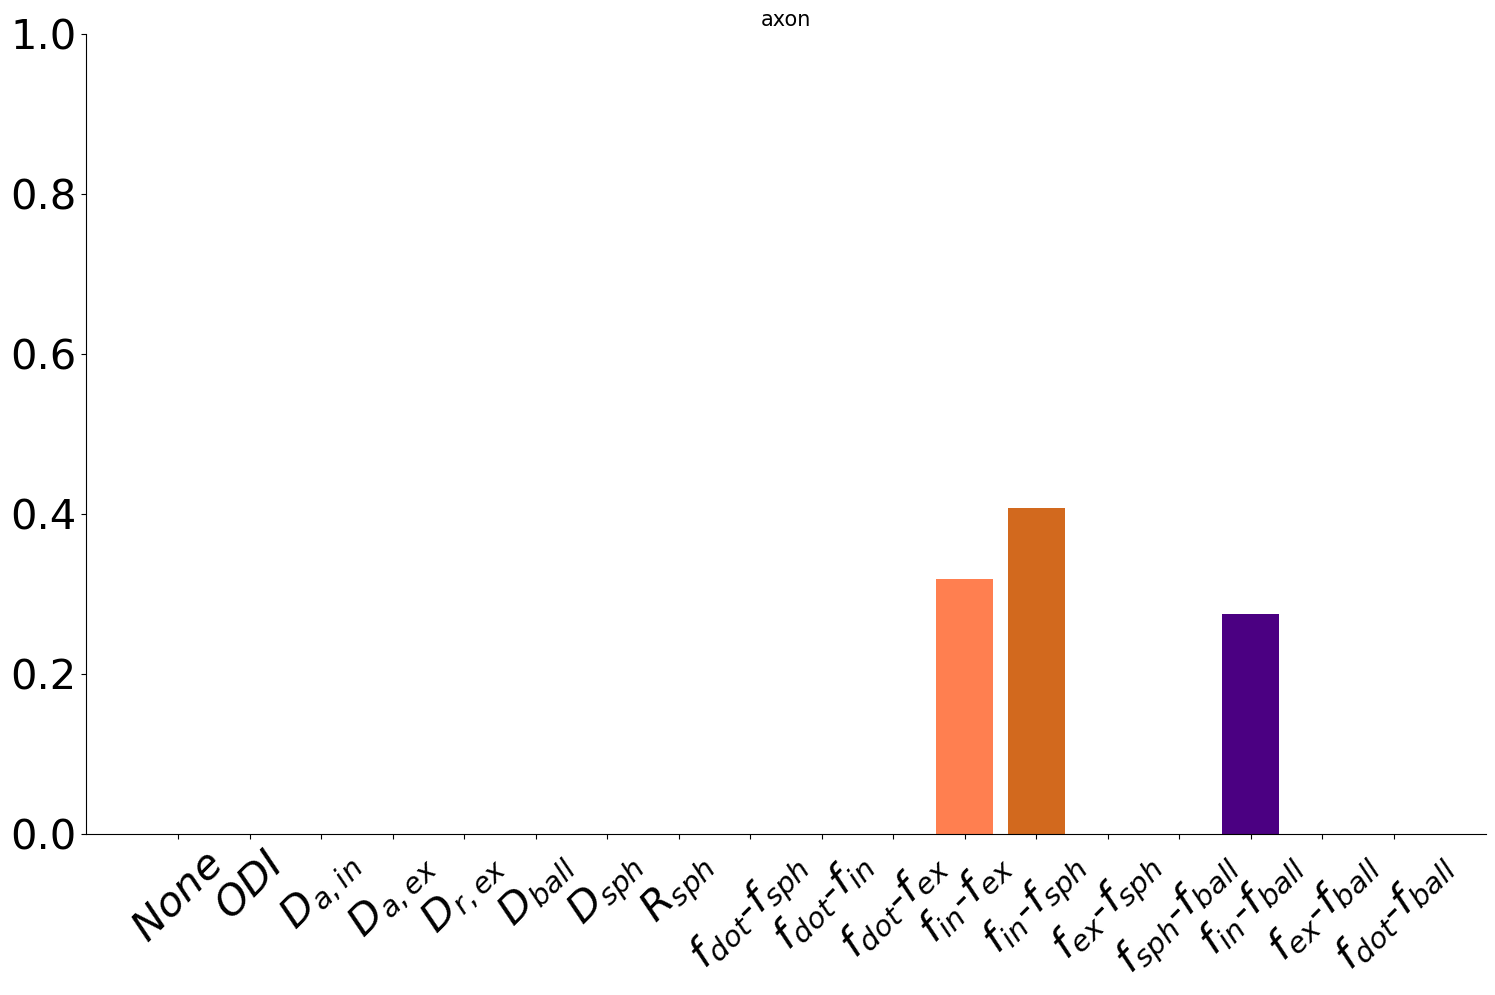

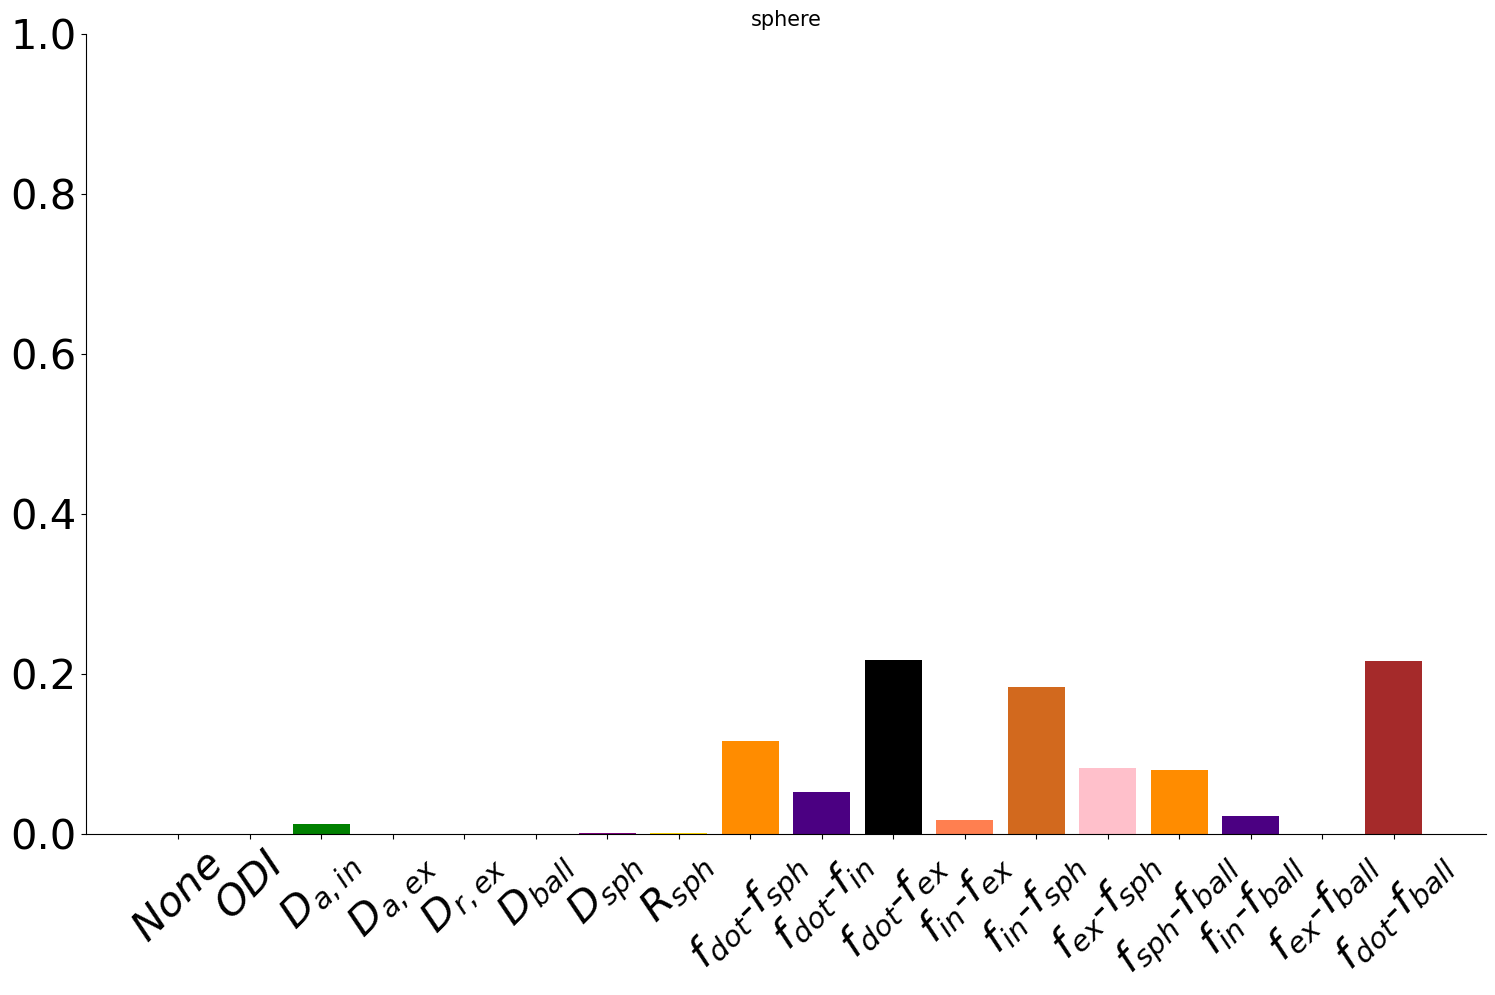

In [49]:
# Plot results

for axe in dictionary_of_axes.keys():
    continuous_change_glm.plot_probs(
        probs=dictionary_of_probs_params[axe].sum(axis=0) / iterations,
        free_params=free_params,
        title=axe,
        ymax=1,
        xticksize=30,
        figsize=(14, 8)
    )
    plt.xticks(rotation=45)
    plt.yticks(size=30)